<a href="https://colab.research.google.com/github/ravishankarramakrishnan/_Projects1_/blob/master/Netflix_Content_Recommendation_W2V.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Netflix Recommendation of Movie Titles using Word 2 Vec
### Content Based Recommendation System

In [1]:
# Importing the Libraries

import numpy as np
import pandas as pd
import re
from matplotlib import pyplot
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import gensim
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from gensim.models import KeyedVectors

import string
import random
from PIL import Image
import requests
from io import BytesIO

import warnings; warnings.filterwarnings('ignore', category=FutureWarning, module= 'gensim')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# Importing the Dataset
data = pd.read_csv("/content/drive/MyDrive/Projects/Netflix Recommendation using W2V/netflix_titles.csv")
data.head(3).append(data.tail(3))

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
6231,80116008,Movie,Little Baby Bum: Nursery Rhyme Friends,NaN,NaN,NaN,NaN,2016,NaN,60 min,Movies,Nursery rhymes and original music for children...
6232,70281022,TV Show,A Young Doctor's Notebook and Other Stories,NaN,"Daniel Radcliffe, Jon Hamm, Adam Godley, Chris...",United Kingdom,NaN,2013,TV-MA,2 Seasons,"British TV Shows, TV Comedies, TV Dramas","Set during the Russian Revolution, this comic ..."
6233,70153404,TV Show,Friends,NaN,"Jennifer Aniston, Courteney Cox, Lisa Kudrow, ...",United States,NaN,2003,TV-14,10 Seasons,"Classic & Cult TV, TV Comedies",This hit sitcom follows the merry misadventure...


In [3]:
# Get the Columns to View

df = data[['title', 'description', 'listed_in']]
df.head(3)

,title,description,listed_in
0,Norm of the North: King Sized Adventure,Before planning an awesome wedding for his gra...,"Children & Family Movies, Comedies"
1,Jandino: Whatever it Takes,Jandino Asporaat riffs on the challenges of ra...,Stand-Up Comedy
2,Transformers Prime,"With the help of three human allies, the Autob...",Kids' TV


In [4]:
# Check Null Values
df.isnull().sum()

title          0
description    0
listed_in      0
dtype: int64

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


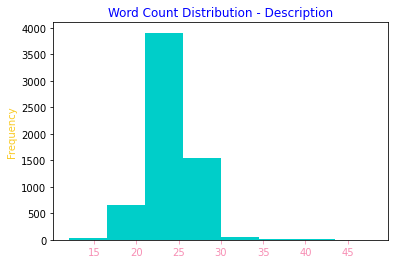

In [5]:
# Visualizing length of Descriptions
df['word_count'] = df['description'].apply(lambda x: len(str(x).split()))

# Plot the Histogram
ax = df['word_count'].plot(
    kind= "hist",
    bins= 8,
    color= '#00cec9',
    figsize= (6,4),
    title= "Word Count Distribution - Description"
);

# Set title Color
ax.title.set_color("Blue")
ax.yaxis.label.set_color("#f9ca24")
ax.xaxis.label.set_color("Blue")
ax.tick_params(axis= 'x', colors= "#f78fb4") # For Ticks

In [6]:
# Typeconversion
df['description'] = df['description'].astype('str')

# Preprocessing Descripions

# Remove Non ASCII (Non English) Charecters and Digits
def non_ascii(string):
    return "".join(i for i in string if ord(i) < 128)

def lower_case(text):
    return text.lower()

def remove_stopwords(text):
    text = text.split()
    sw = set(stopwords.words('english'))
    text = [word for word in text if not word in sw]
    text = " ".join(text)
    return text

def clean_html(text):
    html = re.compile('<.*?>')
    return html.sub(r'', text)

def clean_punct(text):
    token = RegexpTokenizer(r'\w+') # Only Words
    text = token.tokenize(text)
    text = " ".join(text)
    return text


# Whole Data
def clean_all_text(text):
    text = non_ascii(text)
    text = lower_case(text)
    text = remove_stopwords(text)
    text = clean_html(text)
    text = clean_punct(text)
    return text

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
df['cleanedDescription'] = df['description'].apply(lambda x: clean_all_text(x))
df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,title,description,listed_in,word_count,cleanedDescription
0,Norm of the North: King Sized Adventure,Before planning an awesome wedding for his gra...,"Children & Family Movies, Comedies",23,planning awesome wedding grandfather polar bea...
1,Jandino: Whatever it Takes,Jandino Asporaat riffs on the challenges of ra...,Stand-Up Comedy,25,jandino asporaat riffs challenges raising kids...
2,Transformers Prime,"With the help of three human allies, the Autob...",Kids' TV,23,help three human allies autobots protect earth...
3,Transformers: Robots in Disguise,When a prison ship crash unleashes hundreds of...,Kids' TV,20,prison ship crash unleashes hundreds deceptico...
4,#realityhigh,When nerdy high schooler Dani finally attracts...,Comedies,26,nerdy high schooler dani finally attracts inte...


In [8]:
# Universal List
universe = []
for words in df['cleanedDescription']:
    universe.append(words.split())

In [9]:
# Download Word Vectors
!wget -P /root/input/ -c  "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-01-22 10:03:02--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.66.14
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.66.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  17.1MB/s    in 95s     

2021-01-22 10:04:38 (16.5 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [10]:
# Pretrained - Transfer Learning using Embeddings from Google 300 Dimension 
EMBEDDING_FILE = "/root/input/GoogleNews-vectors-negative300.bin.gz"

In [11]:
# Apply Pretrained Model
pretrained_model = Word2Vec(size= 300, window= 5, min_count= 2, workers= -1)
pretrained_model.build_vocab(universe)
# Merge Input hidden weighted matrix - Current Vocab + Pretrained Vocab
pretrained_model.intersect_word2vec_format(EMBEDDING_FILE, lockf= 1.0, binary= True)
pretrained_model.train(universe, total_examples= pretrained_model.corpus_count, epochs= 5)

(0, 0)

In [13]:
pretrained_model.wv.most_similar(['horse'])

[('colt', 0.6765697002410889),
 ('ponies', 0.6296169757843018),
 ('jockey', 0.6133067607879639),
 ('donkey', 0.5702754855155945),
 ('llama', 0.5371144413948059),
 ('dog', 0.4825807213783264),
 ('sheep', 0.47616416215896606),
 ('pig', 0.4698113203048706),
 ('stud', 0.46554455161094666),
 ('trainer', 0.46326494216918945)]

In [17]:
# Calculation
# Positive
print(pretrained_model.wv.most_similar(positive = ['horse'])) # Gives keys that contributes positively
print(pretrained_model.wv.most_similar(negative = ['horse'])) # Gives keys that contributes Negatively

[('colt', 0.6765697002410889), ('ponies', 0.6296169757843018), ('jockey', 0.6133067607879639), ('donkey', 0.5702754855155945), ('llama', 0.5371144413948059), ('dog', 0.4825807213783264), ('sheep', 0.47616416215896606), ('pig', 0.4698113203048706), ('stud', 0.46554455161094666), ('trainer', 0.46326494216918945)]
[('27', 0.13947734236717224), ('grillo', 0.1383214145898819), ('bffs', 0.13581538200378418), ('griffith', 0.12646643817424774), ('masha', 0.11969258636236191), ('jody', 0.11934195458889008), ('mahismati', 0.11756570637226105), ('quevedo', 0.11534534394741058), ('iglesias', 0.11428948491811752), ('tarzan', 0.10916084796190262)]


In [18]:
# Similarity between 2 Words
print(pretrained_model.wv.similarity('king', 'queen'))

0.6510957


In [36]:
# define Vectorize Function - It defines the Average Word2Vec for Each Description from Netflix

def Vectorize(x):
    global embeddings
    # Create a List Embeddings which stores the vectors of the Description
    embeddings = []

    for line in df['cleanedDescription']:
        w2v = None
        count = 0
        for word in line.split():
            if word in pretrained_model.wv.vocab:
                count += 1
                if w2v is None:
                    w2v = pretrained_model.wv[word]
                else:
                    w2v = w2v + pretrained_model.wv[word]
        
        if w2v is not None:
            w2v = w2v / count
            embeddings.append(w2v)

In [37]:
# Define Recommendation Function

def content_recommender(title):
    Vectorize(df)
    cosine_similarities = cosine_similarity(embeddings, embeddings)
    netflix_shows = df[['title']]
    indices = pd.Series(df.index, index= df['title']).drop_duplicates()
    ix = indices[title]
    cosine_sim = list(enumerate(cosine_similarities[ix]))

    # sort the Values
    cosine_sim = sorted(cosine_sim, key= lambda x: x[1], reverse= True)

    cosine_sim = cosine_sim[1:6]
    netflix_index = [i[0] for i in cosine_sim]
    watch_next = netflix_shows.iloc[netflix_index]

    for index, row in watch_next.iterrows():
        print(row['title'])

In [42]:
content_recommender('Friends')

Big Mouth
Hap and Leonard
LEGO Friends: The Power of Friendship
Single Ladies Senior
Workin' Moms


In [43]:
content_recommender('Transformers: Robots in Disguise')

Sonic X
The Shannara Chronicles
Power Rangers S.P.D.
3Below: Tales of Arcadia
Sym-Bionic Titan
